수정사항(2024.04.13 11:12)
- 10배 Oversampling으로 변경, 바꾸고 싶으면 OV 값을 바꾸는 걸로 가능
- 그래프 정상적으로 그릴 수 있게 변경
- code_delay_range 변수 조정 : range(-1600,1600,8) => np.arange(-200,200,0.5)
- 신호 생성 시 delay가 소수점일 때 제대로 작동하지 않는 것을 막기 위해 delay에 곱셈 적용
: code_delay = int(code_delay * 10)
- 기타 수치 조정

## Code 생성

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]

def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

## Oversampling rate 결정

In [188]:
OV = 4
# 확인해 본 sampling : (4,8,10,16,20,32,50,64)
# 여기서 문제 있는 sampling 갯수 : 4, 8, 16, 32 : 바로 옆 delay를 판단해버린다. Ex) 16으로 했을 때 True: 33.25, Est: 33.3125(한 sample 차이)

## 송신단에서의 신호 생성 + Doppler_frequency 적용

In [189]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq=1.023e6, oversampling_factor=(1.023e6)*OV, signal_length=1023*OV):
    # Generate C/A code
    ca_code = np.array(codes[svNumber])
    code_delay = int(code_delay * OV)
    # Apply code delay
    delayed_code = [chip for chip in ca_code for _ in range(OV)]
    delayed_code = np.roll(delayed_code, code_delay)
    # Generate oversampled signal
    t = np.arange(signal_length)
   
    code_phase = 2 * np.pi * code_freq * t / oversampling_factor
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / oversampling_factor))
    
    # Multiply with delayed C/A code
    signal = delayed_code * oversampled_signal[:signal_length]
    
    return signal

## 수신단에서의 Replica 신호 생성(For Acquisition)

In [190]:
def generate_replica_signal(code_delay, doppler_freq, svNumber, code_freq=1.023e6, oversampling_factor=(1.023e6)*OV, signal_length=1023*OV):
    # Generate C/A code
    ca_code = np.array(codes[svNumber])
    code_delay = int(code_delay * OV)
    # Apply code delay
    delayed_code = [chip for chip in ca_code for _ in range(OV)]
    delayed_code = np.roll(delayed_code, code_delay)
    # Generate oversampled signal
    t = np.arange(signal_length)
   
    code_phase = 2 * np.pi * code_freq * t / oversampling_factor
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / oversampling_factor))
    
    # Multiply with delayed C/A code
    signal = delayed_code * oversampled_signal[:signal_length]
    
    return signal

## Acqusition

In [191]:
def acquisition(signal, code_delay_range, doppler_freq_range, svNumber, oversampling_factor=(1.023e6)*OV, signal_length=1023*OV):
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_result = []
    
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
 
    for i, doppler_freq in enumerate(doppler_freq_range):
        # Generate replica signal with the current code delay and Doppler frequency
        reference_signal = generate_replica_signal(code_delay_range[0], doppler_freq, svNumber, oversampling_factor=oversampling_factor, signal_length=signal_length)
        for j, code_delay in enumerate(code_delay_range):
            
            # Calculate correlation between the received signal and the replica signal
            correlation = np.abs(correlate(signal, reference_signal, mode='valid'))
            corr_result.extend(correlate(signal, reference_signal, mode='valid'))
            
            # Find maximum correlation
            peak_corr = np.max(correlation)
            corr_matrix[j, i] = peak_corr
            
            # Update maximum correlation and corresponding code delay and Doppler frequency
            if peak_corr > max_corr:
                max_corr = peak_corr
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
    
            # Shift the reference signal by 0.5 chips for the next iteration
            reference_signal = np.roll(reference_signal, OV//2)
    
    return max_corr, max_code_delay, max_doppler_freq, corr_matrix, corr_result
    


## 실행

In [192]:
# Parameters
code_delay_range = np.arange(-200, 200, 0.5)  # Range of code delay in chips
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = rand.randint(0,36)
# Generate received signal
true_code_delay = rand.randint(-200*OV,200*OV) / OV
true_doppler_freq = rand.randint(-5000,5000)
received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq=code_freq)

# Perform acquisition
max_corr, estimated_code_delay, estimated_doppler_freq, corr_matrix, corr_result = acquisition(received_signal, code_delay_range, doppler_freq_range, svNumber)

print("-"*40)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay)
print("True doppler frequency:", true_doppler_freq)
print("Maximum correlation:", max_corr)
print("Estimated code delay:", estimated_code_delay)
print("Estimated Doppler frequency:", estimated_doppler_freq)

----------------------------------------
Target SV Number: 21
True Code Delay: -106.25
True doppler frequency: -4653
Maximum correlation: 1664.1683520587007
Estimated code delay: -106.0
Estimated Doppler frequency: -5000.0


## Plot

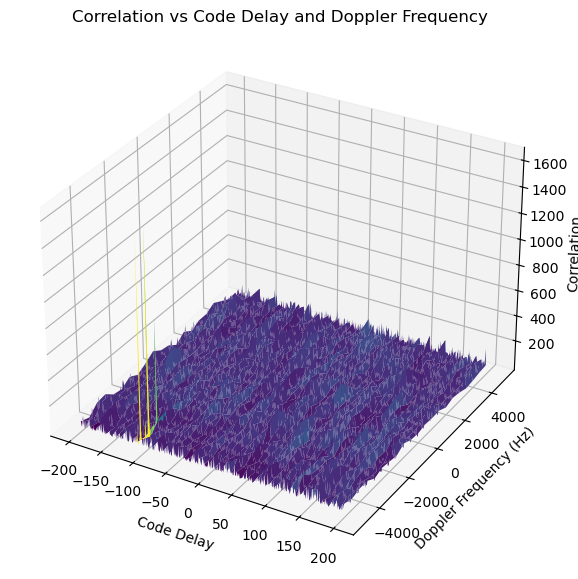

In [193]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()


## DLL test

In [194]:
current_code_delay = estimated_code_delay
error_Amp = 100000
count = 0
while(count < 20):
    print(f'{count}: {current_code_delay}', sep = " ")
    # L,P,E Replica Generation
    Early_code = generate_transmitted_signal(current_code_delay - 0.5, estimated_doppler_freq, svNumber)
    Prompt_code = generate_transmitted_signal(current_code_delay, estimated_doppler_freq, svNumber)
    Late_code = generate_transmitted_signal(current_code_delay + 0.5, estimated_doppler_freq, svNumber)
    # Calculate correlation between the received signal and the replica signal
    cor_E = np.abs(correlate(received_signal, Early_code, mode='valid'))
    E = np.max(cor_E)
    cor_P = np.abs(correlate(received_signal, Prompt_code, mode='valid'))
    P = np.max(cor_P)
    cor_L = np.abs(correlate(received_signal, Late_code, mode='valid'))        
    L = np.max(cor_L)
    print(f'P = {P}, E = {E}, L = {L}')
    error_Amp = (E - L)
    if np.abs(error_Amp) < 1:
        print(f'Matched. Error = {error_Amp}')
        break 
    else:
        if E - L < 0:
            current_code_delay = round(current_code_delay + 1/OV, 10)
        elif E - L > 0:
            current_code_delay = round(current_code_delay - 1/OV, 10)
        count += 1
    
    print()
    
  
print()  
print('L =',L)
print('P =',P)
print('E =',E)

print(f'True: {true_code_delay}, Est: {current_code_delay}')
        
    
    
    

#5000

0: -106.0
P = 1664.1683520587003, E = 888.1998382000114, L = 888.1969296536698
Matched. Error = 0.0029085463415867707

L = 888.1969296536698
P = 1664.1683520587003
E = 888.1998382000114
True: -106.25, Est: -106.0


# PLL

In [195]:
# FFT를 사용하여 주파수 정보 추출
fft_result = np.fft.fft(corr_result)
fft_freqs = np.fft.fftfreq(len(corr_result))

# 주파수 스펙트럼에서 주요 주파수 성분 식별
main_freq_index = np.argmax(np.abs(fft_result))  # 가장 큰 주파수 성분 인덱스 찾기
main_freq = fft_freqs[main_freq_index]  # 해당 주파수 성분 추출

print("주요 주파수 성분:", main_freq)

# FFT 결과에서 주요 주파수 성분을 찾음
main_freq_index = np.argmax(np.abs(fft_result))  # 가장 큰 주파수 성분 인덱스 찾기
main_freq = fft_freqs[main_freq_index]  # 해당 주파수 성분 추출

# 샘플링 주파수의 정수배 여부 확인
signal_length = len(received_signal)
sampling_frequency_multiple = main_freq / signal_length

# 샘플링 주파수 추정
estimated_sampling_frequency = sampling_frequency_multiple * signal_length

print("Estimated Sampling Frequency:", estimated_sampling_frequency)



주요 주파수 성분: -0.42910714285714285
Estimated Sampling Frequency: -0.42910714285714285


In [196]:
import cmath
import math
import numpy as np

# 주어진 복소수 리스트
complex_numbers = corr_result

# 위상을 계산하고 라디안으로 변환하는 함수
def phase_to_radians(complex_num):
    phase = cmath.phase(complex_num)  # 위상을 계산
    phase_radians = phase / math.pi  # 라디안으로 변환
    return phase_radians

# 모든 복소수의 위상을 라디안으로 변환
phases_radians = [phase_to_radians(complex_num) for complex_num in complex_numbers]

# 위상 차이 계산
phase_diffs = [phases_radians[i+1] - phases_radians[i] for i in range(len(phases_radians)-1)]

# 주파수 오차 추정을 위한 상수 계산

sampling_frequency = main_freq*102.4*OV # 샘플링 주파수
phase_difference_constant = sampling_frequency / (2 * math.pi)

# 주파수 오차 추정
frequency_errors = [phase_diff * phase_difference_constant for phase_diff in phase_diffs]

print("주파수 오차 추정 결과:", frequency_errors)


주파수 오차 추정 결과: [-27.20810328938941, 29.86034827712414, 12.631199706022672, -34.693364161979154, -8.388517517966052, 30.050317983530597, -27.43209626234473, 29.922347954908062, 13.584295350950788, -29.8426018841935, 27.658959392148194, -40.05452287684572, 17.689462454932976, 23.498573220089252, -16.747733731630653, -26.62485558961303, 28.367110522231616, -26.70067388612801, -0.41310710970236764, 28.236489385313224, -32.467233276184494, 7.073391856251124, 36.14452750040976, -24.744814497336886, 26.190373504314415, -36.8769905832987, 13.383647442907533, 25.950852160427733, -26.97839053841822, -18.560892740716273, 32.8346057939028, -26.1736524255769, 28.393510777772647, -27.00876312911407, 27.525227785415986, -28.099818077627937, 33.386106354444685, -5.488330019244461, -2.022267387893869, -26.8451900666829, 28.348098828376905, -1.3965745666737224, -27.70324170613479, 28.15392863876213, -30.37941736512457, 20.81554948268981, 14.608033591646876, -30.42740345793814, -5.620517142801206, 31.5474

In [197]:
corrected_frequencies = [estimated_doppler_freq - error for error in frequency_errors]


print("True doppler frequency:", true_doppler_freq)
print()
print("Estimated Doppler frequency:", estimated_doppler_freq)
print("보정된 주파수:", corrected_frequencies[-1])

True doppler frequency: -4653

Estimated Doppler frequency: -5000.0
보정된 주파수: -5001.423996798957


In [198]:
import cmath
import math
import numpy as np

# 주어진 복소수 리스트
complex_numbers = corr_result

# 위상을 계산하고 라디안으로 변환하는 함수
def phase_to_radians(complex_num):
    phase = cmath.phase(complex_num)  # 위상을 계산
    phase_radians = phase / math.pi  # 라디안으로 변환
    return phase_radians

# 모든 복소수의 위상을 라디안으로 변환
phases_radians = [phase_to_radians(complex_num) for complex_num in complex_numbers]

# 위상 차이 계산
phase_diffs = [phases_radians[i+1] - phases_radians[i] for i in range(len(phases_radians)-1)]

# 주파수 오차 추정을 위한 상수 계산
sampling_frequency = sampling_frequency  # 샘플링 주파수
phase_difference_constant = sampling_frequency / (2 * math.pi)

# 주파수 오차 추정
frequency_errors = [phase_diff * phase_difference_constant for phase_diff in phase_diffs]

print("주파수 오차 추정 결과:", frequency_errors)


corrected_frequencies = [estimated_doppler_freq - error for error in frequency_errors]

print("보정된 주파수:", corrected_frequencies[-1])


주파수 오차 추정 결과: [-27.20810328938941, 29.86034827712414, 12.631199706022672, -34.693364161979154, -8.388517517966052, 30.050317983530597, -27.43209626234473, 29.922347954908062, 13.584295350950788, -29.8426018841935, 27.658959392148194, -40.05452287684572, 17.689462454932976, 23.498573220089252, -16.747733731630653, -26.62485558961303, 28.367110522231616, -26.70067388612801, -0.41310710970236764, 28.236489385313224, -32.467233276184494, 7.073391856251124, 36.14452750040976, -24.744814497336886, 26.190373504314415, -36.8769905832987, 13.383647442907533, 25.950852160427733, -26.97839053841822, -18.560892740716273, 32.8346057939028, -26.1736524255769, 28.393510777772647, -27.00876312911407, 27.525227785415986, -28.099818077627937, 33.386106354444685, -5.488330019244461, -2.022267387893869, -26.8451900666829, 28.348098828376905, -1.3965745666737224, -27.70324170613479, 28.15392863876213, -30.37941736512457, 20.81554948268981, 14.608033591646876, -30.42740345793814, -5.620517142801206, 31.5474